In [1]:
import sys
import os
import matplotlib.pyplot as plt

# TFC training

In [2]:
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/model')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/trainer')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/dataloader')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/SleepEEG_Configs')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/HAR_Configs')
sys.path.append('/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/config_files/FOG_Configs')


In [3]:
import torch
from torch import nn
from model import TFC, target_classifier
from dataloader import data_generator
from trainer import model_pretrain


In [4]:
torch.backends.mps.is_available()

True

### define configs

In [5]:
# from SleepEEG_Configs import Config as Configs

# SEED = 42
# arch = 'sleep_EEG'
# save_model_path = 'experiment_logs/pretrainmodel/'
# sourcedata_path = '../datasets/SleepEEG/'
# targetdata_path = '../datasets/Epilepsy/'

In [6]:
from FOG_Configs import Config as Configs

SEED = 42
arch = 'FOG'
save_model_path = 'experiment_logs/pretrainmodel/'
sourcedata_path = '../datasets/FOG_pretrain/'
targetdata_path = '../datasets/Gesture/'

In [15]:
training_mode = 'pre_train'
subset = False


device = torch.device("mps")
configs = Configs()

In [16]:
configs.input_channels

1

### create TFC model and finetuning classifier

In [17]:
TFC_model = TFC(configs).to(device)

### create optimizers

In [18]:
model_optimizer = torch.optim.Adam(TFC_model.parameters(), lr=configs.lr, betas=(configs.beta1, configs.beta2), weight_decay=3e-4)

criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, 'min')

### load datasets

In [19]:
train_dl, _, _ = data_generator(sourcedata_path, targetdata_path, configs, training_mode, subset=subset)

In [20]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [21]:
data.shape

torch.Size([128, 1, 500])

In [22]:
# idx = 80
# plt.plot(aug1[idx,0,:].numpy())
# plt.plot(data[idx,0,:].numpy())
# plt.show()

# plt.plot(aug1_f[0,0,:].numpy())
# plt.plot(data_f[idx,0,:].numpy())
# plt.ylim(0,10)

### finetune and test loop

In [23]:
### Pretraining on source dataset

for epoch in range(1, configs.num_epoch + 1):

    train_loss = model_pretrain(TFC_model, model_optimizer, criterion, train_dl, configs, device, training_mode)


os.makedirs(save_model_path, exist_ok=True)
chkpoint = {'model_state_dict': TFC_model.state_dict()}
torch.save(chkpoint, os.path.join(save_model_path, f'{arch}_ckp_last.pt'))

/Users/giovanni/Documents/Atai/projects/tfc_pretrain/TFC-pretraining/code/TFC/loss.py:119: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)


Pretraining: overall loss:9.48289680480957, l_t: 6.08815336227417, l_f:6.595750331878662, l_c:6.946115493774414
Pretraining: overall loss:9.364482879638672, l_t: 6.109065532684326, l_f:6.546109676361084, l_c:6.833447456359863
Pretraining: overall loss:9.266663551330566, l_t: 6.206289291381836, l_f:6.535274028778076, l_c:6.718350410461426
Pretraining: overall loss:9.159894943237305, l_t: 6.29329252243042, l_f:6.539393424987793, l_c:6.593358039855957
Pretraining: overall loss:9.098553657531738, l_t: 6.165281295776367, l_f:6.53618860244751, l_c:6.558259963989258
Pretraining: overall loss:9.103350639343262, l_t: 6.210666179656982, l_f:6.544307708740234, l_c:6.552355766296387
Pretraining: overall loss:9.065276145935059, l_t: 6.051871299743652, l_f:6.535624980926514, l_c:6.54777717590332
Pretraining: overall loss:9.128664016723633, l_t: 6.342955589294434, l_f:6.540048599243164, l_c:6.55206298828125
Pretraining: overall loss:9.151665687561035, l_t: 6.412355422973633, l_f:6.540017604827881, l_

### visualise embeddings of training set

In [24]:
from sklearn.manifold import TSNE

In [46]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [47]:
data

tensor([[[ 0.7969,  0.7969,  0.7969,  ...,  0.7969,  0.7969,  0.7969]],

        [[ 0.3281,  0.3209,  0.3194,  ...,  0.3281,  0.3281,  0.3186]],

        [[ 0.9844,  0.9790,  0.9688,  ...,  0.9844,  0.9844,  0.9844]],

        ...,

        [[-0.0770, -0.0781, -0.0781,  ..., -0.0781, -0.0696, -0.0707]],

        [[-0.8959, -0.9199, -1.1699,  ..., -0.3611, -0.3042, -0.3086]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  0.9858,  0.9844]]],
       dtype=torch.float64)

In [48]:
h_t, z_t, h_f, z_f = TFC_model(data.to(torch.float32).to(device), data_f.to(torch.float32).to(device))
fea_concat = torch.cat((z_t, z_f), dim=1)
fea_concat = fea_concat.to('cpu').detach().numpy()

In [49]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(fea_concat)

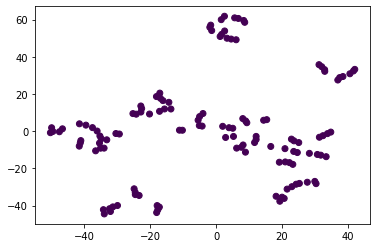

In [50]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=list(labels.numpy()))

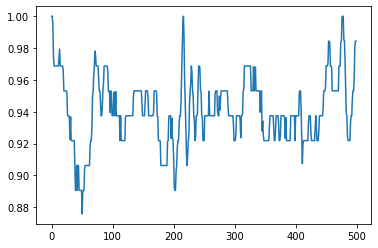

In [51]:
plt.plot(data.numpy()[92,0,:])

In [60]:
data, labels, aug1, data_f, aug1_f = next(iter(train_dl))

In [61]:
data.shape

torch.Size([128, 1, 500])